<a href="https://colab.research.google.com/github/StanleyLiangYork/GAN_for_Medical_Image/blob/main/Cycle_GAN_with_Criterion_COVID_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.2 MB/s 


In [59]:
!pip install sewar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sewar: filename=sewar-0.4.5-py3-none-any.whl size=10608 sha256=ff890665c3fa291604e04ab561cb26d9c3be68ded28b7d98af52cfa98ab162f5
  Stored in directory: /root/.cache/pip/wheels/7a/38/6b/d066cfcb2b1c1c9b059b9ce1bdc4803b469359214e8dad4e3e
Successfully built sewar


In [60]:
from sewar.full_ref import mse, rmse, psnr, uqi, ssim, ergas, scc, rase, sam, msssim, vifp

In [2]:
import os
import shutil
import random
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import zipfile
import random
from PIL import Image
from matplotlib import pyplot as plt
import re
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import tensorflow_hub as hub
import cv2
import tensorflow_addons as tfa
import tensorflow_probability as tfp


print(f'Tensorflow Version: {tf.__version__}')

Tensorflow Version: 2.8.2


Set the random seed for replication

In [3]:
tf.random.set_seed(100)

Fetch the COVID-19 X-Ray dataset

In [4]:
if not os.path.exists('covid_set.zip'):
  !wget https://storage.googleapis.com/pet-detect-239118/covid_set.zip ./covid_set.zip

with zipfile.ZipFile('covid_set.zip') as ZipObj:
  ZipObj.extractall()

--2022-08-22 03:19:22--  https://storage.googleapis.com/pet-detect-239118/covid_set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.193.128, 172.217.204.128, 172.217.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1233041157 (1.1G) [application/zip]
Saving to: ‘covid_set.zip’

covid_set.zip       100%[===================>]   1.15G   136MB/s    in 10s     

2022-08-22 03:19:33 (115 MB/s) - ‘covid_set.zip’ saved [1233041157/1233041157]

--2022-08-22 03:19:33--  http://./covid_set.zip
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2022-08-22 03:19:33--
Total wall clock time: 10s
Downloaded: 1 files, 1.1G in 10s (115 MB/s)


Set the folders for the experiment

In [5]:
root_dir = '/content/covid_set'
paths = os.listdir(root_dir)

covid = re.compile("COVID")
normal = re.compile("NORMAL")
viral = re.compile("Viral")

covid_path = []
normal_path = []
viral_path = []

In [6]:
for path in paths:
  if covid.match(path):
    covid_path.append(path)
  if normal.match(path):
    normal_path.append(path)
  if viral.match(path):
    viral_path.append(path)

Since we have just a few COVID-19 X-ray images, we separate 50 images for validation, and the rest 169 for training

In [7]:
val_covid_path = covid_path[:50]
covid_path = covid_path[50:]
print(len(val_covid_path))
print(len(covid_path))

50
169


Randomly resample the images

In [8]:
for _ in range(5):
  random_items = random.sample(covid_path, 169)
  covid_path += random_items

print(len(covid_path))

1014


Build a balanced dataset, each class has 1014 images respectively

In [9]:
for i, path in enumerate(covid_path):
  covid_path[i] = root_dir + '/' + path

for i, path in enumerate(normal_path):
  normal_path[i] = root_dir + '/' + path

for i, path in enumerate(viral_path):
  viral_path[i] = root_dir + '/' + path


# 1014 + 50 = 1064 -- need 50 extra images from normal and from viral classes for the validation dataset
covid_path = covid_path
normal_path = normal_path[:1064]
viral_path = viral_path[:1064]

In [10]:
print(len(covid_path))
print(len(normal_path))
print(len(viral_path))

1014
1064
1064


The helper function the resize and rescale the images.<p>
labels: COVID-0, NORMAL-1, VIRAL-2

In [11]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [128, 128])


def get_label(file_path):
  if tf.strings.regex_full_match(file_path, ".*COVID.*"):
    return tf.constant(0.0, dtype="float32")
  elif tf.strings.regex_full_match(file_path, ".*NORMAL.*"):
    return tf.constant(1.0, dtype="float32")
  else:
    return tf.constant(2.0, dtype="float32")


def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)

  # rescale from (0,255) to (0,1)
  # img = img / 255.0
  img = (img - 127.5) / 127.5
  return img, label

The three image datasets for each image class 

In [12]:
covid_ds = tf.data.Dataset.list_files(covid_path, shuffle=True)
normal_ds = tf.data.Dataset.list_files(normal_path[:1014], shuffle=True)
viral_ds = tf.data.Dataset.list_files(viral_path[:1014], shuffle=True)

In [13]:
BATCH_SIZE = 64
BUFFER_SIZE = 1014
AUTOTUNE = tf.data.AUTOTUNE

covid_ds = covid_ds.map(process_path, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
normal_ds = normal_ds.map(process_path, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
viral_ds = viral_ds.map(process_path, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [14]:
train_path = covid_path + normal_path[:1014] + viral_path[:1014]
val_path = val_covid_path + normal_path[1014:] + viral_path[1014:]
print(len(train_path))
print(len(val_path))

3042
150


In [16]:
train_ds = tf.data.Dataset.list_files(train_path, shuffle=True)
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE).shuffle(3042).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.list_files(val_path, shuffle=True)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE).shuffle(150).batch(BATCH_SIZE)

In [17]:
images, labels = next(iter(train_ds))

visualize the images

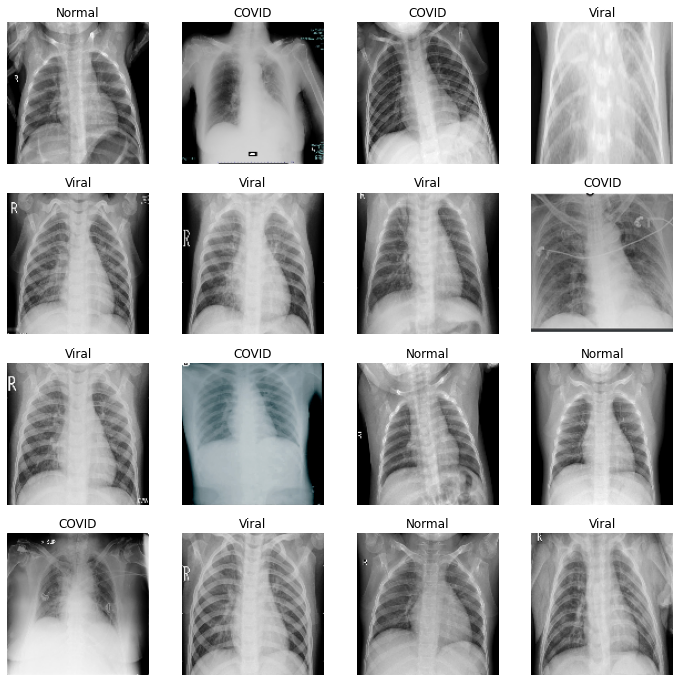

In [18]:
plt.figure(figsize=(12,12))

for i in range(4 * 4):
  plt.subplot(4, 4, 1+i)
  plt.axis(False)
  image = tf.keras.preprocessing.image.array_to_img(images[i,:,:,:])
  plt.imshow(image)
  if labels[i] == 0.0:
    plt.title('COVID')
  if labels[i] == 1.0:
    plt.title("Normal")
  if labels[i] == 2.0:
    plt.title("Viral")

Train the classifier later as the criterion for the GAN

In [19]:
# function for creating an identity or projection residual module
def residual_module(layer_in, n_filters):
	merge_input = layer_in
	# check if the number of filters needs to be increase, assumes channels last format
	if layer_in.shape[-1] != n_filters:
		merge_input = tfkl.Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
	# conv1
	conv1 = tfkl.Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
	# conv2
	conv2 = tfkl.Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
	# add filters, assumes filters/channels last
	layer_out = tfk.layers.Add()([conv2, merge_input])
	# activation function
	layer_out = tfkl.Activation('relu')(layer_out)
	return layer_out

In [20]:
def define_classifier(input_dim=(128,128,3)):
  input_layer = tfk.Input(shape=input_dim)
  layer = tfkl.Lambda(lambda x: x*127.5+127.5)(input_layer)
  layer = residual_module(layer, 64)
  layer = tfkl.BatchNormalization()(layer)
  layer = tfkl.MaxPooling2D()(layer)
  layer = residual_module(layer, 64)
  layer = tfkl.BatchNormalization()(layer)
  layer = tfkl.MaxPooling2D()(layer)
  layer = residual_module(layer, 64)
  layer = tfkl.BatchNormalization()(layer)
  layer = tfkl.MaxPooling2D()(layer)
  layer = residual_module(layer, 64)
  layer = tfkl.BatchNormalization()(layer)
  layer = tfkl.MaxPooling2D()(layer)
  layer = tfkl.Flatten()(layer)
  layer = tfkl.Dense(128, activation='tanh')(layer)
  layer = tfkl.Dropout(0.4)(layer)
  layer = tfkl.Dense(128, activation='tanh')(layer)
  layer = tfkl.Dropout(0.4)(layer)
  layer = tfkl.Dense(3)(layer)
  model = tfk.models.Model(inputs=input_layer, outputs=layer)
  return model

In [21]:
classifier = define_classifier()
classifier.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  1792        ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

Compile the classifer DNN with sparce categorical crossentropy as the loss function, the input label with shape (batch, 1), the DNN output with shape (batch, 3)

In [ ]:
classifier.compile(
    optimizer=tfk.optimizers.Adam(learning_rate=1e-4),
    loss=tfk.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

Optimize with 60 epochs

In [ ]:
history = classifier.fit(train_ds, validation_data=val_ds, epochs=60, callbacks=[callback], verbose=2)

Epoch 1/60
48/48 - 69s - loss: 0.6126 - accuracy: 0.7518 - val_loss: 2.1630 - val_accuracy: 0.5000 - 69s/epoch - 1s/step
Epoch 2/60
48/48 - 55s - loss: 0.2453 - accuracy: 0.9122 - val_loss: 0.5884 - val_accuracy: 0.8000 - 55s/epoch - 1s/step
Epoch 3/60
48/48 - 54s - loss: 0.1799 - accuracy: 0.9405 - val_loss: 0.7898 - val_accuracy: 0.6500 - 54s/epoch - 1s/step
Epoch 4/60
48/48 - 53s - loss: 0.1187 - accuracy: 0.9612 - val_loss: 0.5154 - val_accuracy: 0.7700 - 53s/epoch - 1s/step
Epoch 5/60
48/48 - 53s - loss: 0.0888 - accuracy: 0.9740 - val_loss: 0.7431 - val_accuracy: 0.6700 - 53s/epoch - 1s/step
Epoch 6/60
48/48 - 53s - loss: 0.0717 - accuracy: 0.9780 - val_loss: 0.3378 - val_accuracy: 0.8700 - 53s/epoch - 1s/step
Epoch 7/60
48/48 - 53s - loss: 0.0549 - accuracy: 0.9836 - val_loss: 0.2608 - val_accuracy: 0.9000 - 53s/epoch - 1s/step
Epoch 8/60
48/48 - 53s - loss: 0.0414 - accuracy: 0.9885 - val_loss: 0.2165 - val_accuracy: 0.9400 - 53s/epoch - 1s/step
Epoch 9/60
48/48 - 53s - loss: 0

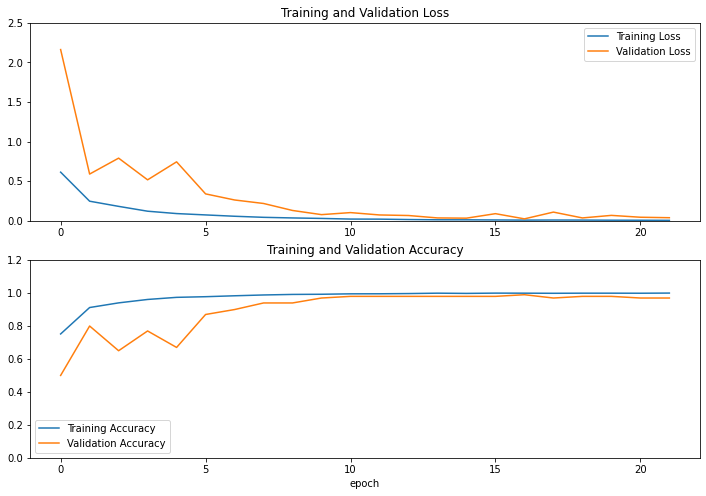

In [ ]:
# visualize the training procedure
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.ylim([0, 2.5])
plt.legend(loc='best')
plt.title('Training and Validation Loss')

plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.ylim([0, 1.2])
plt.plot()
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')
plt.savefig('train.png')

In [ ]:
# save and zip the classifier
classifier.save('covid_classifier_128')
!zip -r covid_classifier_128.zip covid_classifier_128

INFO:tensorflow:Assets written to: covid_classifier_128/assets
  adding: covid_classifier_128/ (stored 0%)
  adding: covid_classifier_128/assets/ (stored 0%)
  adding: covid_classifier_128/variables/ (stored 0%)
  adding: covid_classifier_128/variables/variables.index (deflated 76%)
  adding: covid_classifier_128/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: covid_classifier_128/saved_model.pb (deflated 90%)
  adding: covid_classifier_128/keras_metadata.pb (deflated 94%)


Now we setup the Cycle-GAN with criterion

In [23]:
from zipfile import ZipFile

with ZipFile('covid_classifier_128.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [24]:
# delete and reload the pretrained classifier
# del classifier
classifier = tfk.models.load_model('covid_classifier_128')
classifier.trainable = False

In [25]:
# check the pretrained classifier with the validation dataset
classifier.evaluate(val_ds)

2/2 [==============================] - 12s 204ms/step - loss: 0.0482 - accuracy: 0.9900


[0.04818662256002426, 0.9900000095367432]

In [26]:
class_loss = tfk.losses.SparseCategoricalCrossentropy(from_logits=True)

In [27]:
def get_accuracy(g_true, preds):
  pred_idx = tf.argmax(preds, axis=1).numpy()
  count = 0
  for tab, pred in zip(g_true, pred_idx):
    if tab == pred:
      count += 1
  return count / preds.shape[0]

In [28]:
preds = classifier(images)

In [29]:
result = get_accuracy(labels, preds)
print(result)

1.0


In [30]:
loss = class_loss(labels, preds)
print(loss)

tf.Tensor(1.7457089e-05, shape=(), dtype=float32)


In [31]:
# define the discriminator model
def define_discriminator(image_shape=(128,128,3)):
  init = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.02)
  in_image = tf.keras.Input(shape=image_shape)
  d = tf.keras.layers.Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image) # 64*64*64
  d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
  d = tf.keras.layers.Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d) # 32*32*128
  d = tfa.layers.InstanceNormalization(axis=-1, center=True, scale=True, beta_initializer="random_uniform", gamma_initializer="random_uniform")(d)
  d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
  d = tf.keras.layers.Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d) # 16*16*256
  d = tfa.layers.InstanceNormalization(axis=-1, center=True, scale=True, beta_initializer="random_uniform", gamma_initializer="random_uniform")(d)
  d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
  d = tf.keras.layers.Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d) # 8*8*512
  d = tfa.layers.InstanceNormalization(axis=-1, center=True, scale=True, beta_initializer="random_uniform", gamma_initializer="random_uniform")(d)
  d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
  patch_out = tf.keras.layers.Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d) # 8*8*1
  model = tf.keras.Model(inputs=in_image, outputs=patch_out)
  return model

In [32]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tfkl.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tfa.layers.InstanceNormalization(axis=-1, center=True, scale=True, beta_initializer="random_uniform", gamma_initializer="random_uniform"))

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [33]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tfkl.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tfa.layers.InstanceNormalization(axis=-1, center=True, scale=True, beta_initializer="random_uniform", gamma_initializer="random_uniform"))

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [34]:
def define_generator():
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  down_stack = [
    downsample(64, 4),  # (bs, 64, 64, 64)
    downsample(128, 4),  # (bs, 32, 64, 128)
    downsample(256, 4),  # (bs, 16, 16, 256)
    downsample(512, 4),  # (bs, 8, 8, 512)
    downsample(512, 4),  # (bs, 4, 4, 512)
    downsample(512, 4),  # (bs, 2, 2, 512)
    downsample(512, 4),  # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4),  # (bs, 2, 2, 1024)
    upsample(512, 4),  # (bs, 4, 4, 1024)
    upsample(512, 4),  # (bs, 8, 8, 1024)
    upsample(256, 4),  # (bs, 16, 16, 512)
    upsample(128, 4),  # (bs, 32, 32, 256)
    upsample(64, 4),  # (bs, 64, 64, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(3, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (bs, 128, 128, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [35]:
image_shape = (128,128,3)

generator_g = define_generator()
generator_f = define_generator()
discriminator_x = define_discriminator(image_shape)
discriminator_y = define_discriminator(image_shape)

In [36]:
discriminator_x.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_23 (Conv2D)          (None, 64, 64, 64)        3136      
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 64, 64, 64)        0         
                                                                 
 conv2d_24 (Conv2D)          (None, 32, 32, 128)       131200    
                                                                 
 instance_normalization_26 (  (None, 32, 32, 128)      256       
 InstanceNormalization)                                          
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                           

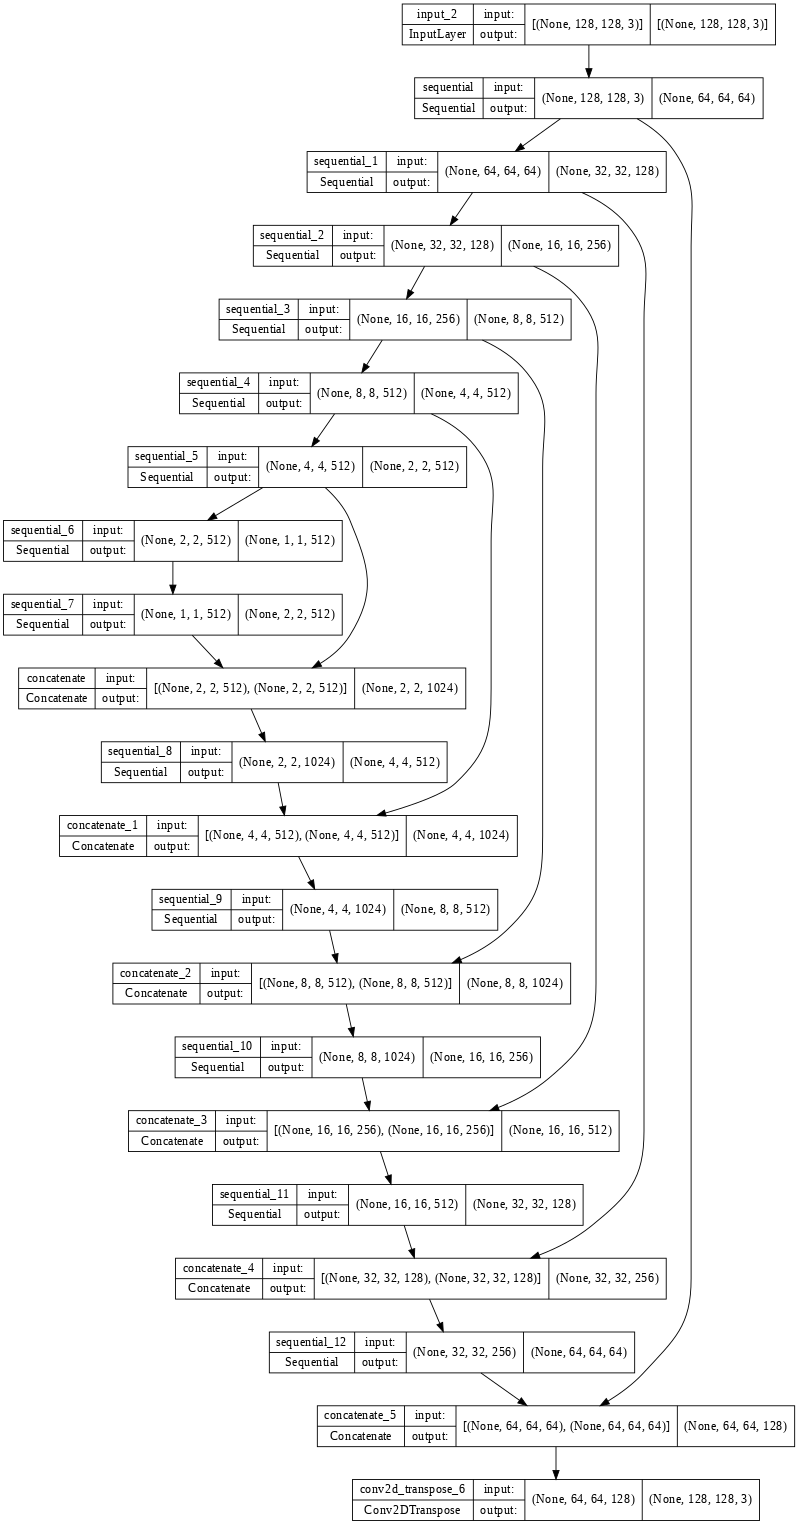

In [37]:
tfk.utils.plot_model(generator_g, show_shapes=True, dpi=64)

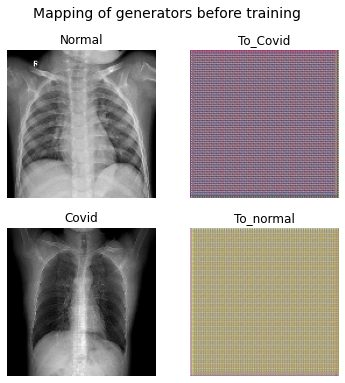

In [38]:
# x -> y: normal -> covid - generator_g
# y -> x: covid -> normal - generator_f

c_images, _ = next(iter(covid_ds))
n_images, _ = next(iter(normal_ds))

to_covid = generator_g(n_images)
to_normal = generator_f(c_images)
plt.figure(figsize=(6, 6))

imgs = [n_images, to_covid, c_images, to_normal]
title = ['Normal', 'To_Covid', 'Covid', 'To_normal']

plt.imshow(tf.keras.preprocessing.image.array_to_img(imgs[0][0]))
plt.suptitle("Mapping of generators before training", fontsize=14)
for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  plt.axis(False)
  if i % 2 == 0:
    plt.imshow(tf.keras.preprocessing.image.array_to_img(imgs[i][0]))
  else:
    plt.imshow(tf.keras.preprocessing.image.array_to_img(imgs[i][0]))
plt.show()


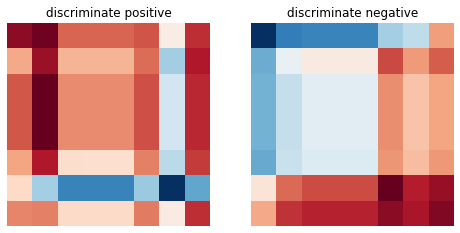

In [39]:
# the hotmap of untrained discriminator
plt.figure(figsize=(8,8))
plt.subplot(121)
plt.title('discriminate positive')
plt.axis(False)
plt.imshow(discriminator_y(c_images)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('discriminate negative')
plt.axis(False)
plt.imshow(discriminator_x(n_images)[0, ..., -1], cmap='RdBu_r')
plt.show()

Define the loss functions for the GAN components

In [40]:
LAMBDA = 80
# alternative: MSE
# loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)
loss_obj = tfk.losses.MeanSquaredError()

def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)
  generated_loss = loss_obj(tf.zeros_like(generated), generated)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss * 0.5


def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)


def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

# prevser color
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [41]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [42]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [43]:
EPOCHS = 600

def generate_images(model, test_input):
  prediction = model(test_input)
  idx = int(np.random.choice(16, 1, replace=False))
  plt.figure(figsize=(10, 10))
  

  display_list = [test_input[idx], prediction[idx]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [44]:
def classify_normal_loss(y, batch_size):
  true_normal = tf.ones([batch_size,1])
  pred_y = classifier(y)
  return class_loss(true_normal, pred_y)


def classify_covid_loss(x, batch_size):
  true_covid = tf.zeros([batch_size,1])
  pred_x = classifier(x)
  return class_loss(true_covid, pred_x)

In [45]:
def train_step(real_x, real_y, c_flag=True):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  batch_size = real_x.shape[0]
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    # calculate classifier loss
    # true_normal = tf.ones([batch_size,])
    # true_covid = tf.zeros([batch_size,])
    pred_same_x = classifier(same_x)
    pred_same_y = classifier(same_y)
    pred_cycled_x = classifier(cycled_x)
    pred_cycled_y = classifier(cycled_y)

    c_loss_x = classify_normal_loss(same_x, batch_size) + classify_normal_loss(cycled_x, batch_size)
    c_loss_x = c_loss_x * 0.1
    
    c_loss_y = classify_covid_loss(same_y, batch_size) + classify_covid_loss(cycled_y, batch_size)
    c_loss_y = c_loss_y * 0.1

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    if (c_flag):
      total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y) + c_loss_y
      total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x) + c_loss_x
    else:
      total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
      total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))
  
  return c_loss_x, c_loss_y, total_cycle_loss, total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss

Build the dataset for the GAN training

In [46]:
def process_gan_path(file_path):
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  img = (img - 127.5) / 127.5
  return img

In [47]:
covid_dataset = tf.data.Dataset.list_files(covid_path, shuffle=True)
normal_dataset = tf.data.Dataset.list_files(normal_path[:1014], shuffle=True)

In [48]:
BUFFER_SIZE = 1014
BATCH_SIZE = 64

covid_dataset = covid_dataset.map(process_gan_path, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
normal_dataset = normal_dataset.map(process_gan_path, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

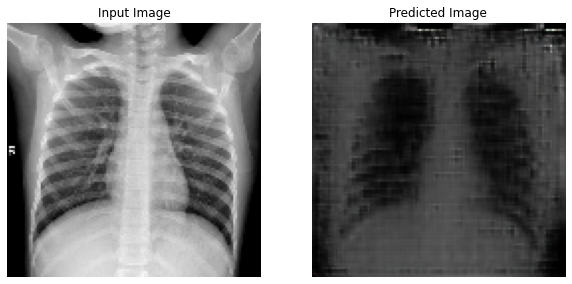

Saving checkpoint for epoch 600 at ./checkpoints/train/ckpt-60
Time taken for epoch 600 is 28.20087504386902 sec



In [49]:
import time
from IPython.display import clear_output
from IPython import display

history = {}
history['class_loss_x'] = []
history['class_loss_y'] = []
history['cycle_loss'] = []
history['total_gen_g_loss'] = []
history['total_gen_f_loss'] = []
history['disc_loss_x'] = []
history['disc_loss_y'] = []
history['used_time'] = []

c_loss_x_mean = tfk.metrics.Mean()
c_loss_y_mean = tfk.metrics.Mean()
cycle_loss_mean = tfk.metrics.Mean()
total_gen_g_loss_mean = tfk.metrics.Mean()
total_gen_f_loss_mean = tfk.metrics.Mean()
disc_loss_x_mean = tfk.metrics.Mean()
disc_loss_y_mean = tfk.metrics.Mean()
uesed_time_mean = tfk.metrics.Mean()


for epoch in range(600):
  start = time.time()
  c_loss_x_mean.reset_state()
  c_loss_y_mean.reset_state()
  cycle_loss_mean.reset_state()
  total_gen_g_loss_mean.reset_state()
  total_gen_f_loss_mean.reset_state()
  disc_loss_x_mean.reset_state()
  disc_loss_y_mean.reset_state()
  uesed_time_mean.reset_state()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((normal_dataset, covid_dataset)):
    if (n % 10 == 0):
      c_loss_x, c_loss_y, total_cycle_loss, total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss = train_step(image_x, image_y, c_flag=True) # chang c_flag to False if want to remove the criterion
    else:
      c_loss_x, c_loss_y, total_cycle_loss, total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss = train_step(image_x, image_y, c_flag=False)
    c_loss_x_mean.update_state(c_loss_x)
    c_loss_y_mean.update_state(c_loss_y)
    cycle_loss_mean.update_state(total_cycle_loss)
    total_gen_g_loss_mean.update_state(total_gen_g_loss)
    total_gen_f_loss_mean.update_state(total_gen_f_loss)
    disc_loss_x_mean.update_state(disc_x_loss)
    disc_loss_y_mean.update_state(disc_y_loss)
    uesed_time_mean.update_state(time.time()-start)

    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, n_images)

  if (epoch + 1) % 10 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
  history['class_loss_x'].append(c_loss_x_mean.result().numpy())
  history['class_loss_y'].append(c_loss_y_mean.result().numpy())
  history['cycle_loss'].append(cycle_loss_mean.result().numpy())
  history['total_gen_g_loss'].append(total_gen_g_loss_mean.result().numpy())
  history['total_gen_f_loss'].append(total_gen_f_loss_mean.result().numpy())
  history['disc_loss_x'].append(disc_loss_x_mean.result().numpy())
  history['disc_loss_y'].append(disc_loss_y_mean.result().numpy())
  history['used_time'].append(uesed_time_mean.result().numpy())

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

Visualize the loss values of the generators and discriminators

In [50]:
# save the trained 
generator_g.save('covid_generator_128')
!zip -r covid_generator_128.zip covid_generator_128

  adding: covid_generator_128/ (stored 0%)
  adding: covid_generator_128/assets/ (stored 0%)
  adding: covid_generator_128/variables/ (stored 0%)
  adding: covid_generator_128/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: covid_generator_128/variables/variables.index (deflated 66%)
  adding: covid_generator_128/keras_metadata.pb (deflated 96%)
  adding: covid_generator_128/saved_model.pb (deflated 92%)


Text(0.5, 51.00000000000006, 'epoch')

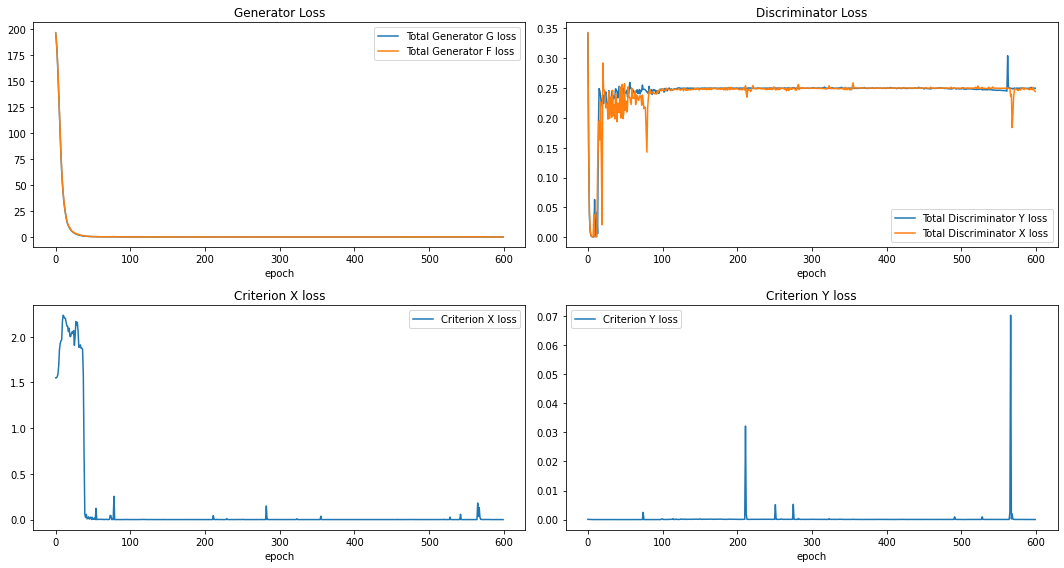

In [51]:
plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
plt.plot(history['total_gen_g_loss'], label='Total Generator G loss')
plt.plot(history['total_gen_f_loss'], label='Total Generator F loss')
plt.legend(loc='best')
plt.title('Generator Loss')
plt.xlabel('epoch')

plt.subplot(2, 2, 2)

plt.plot(history['disc_loss_y'], label='Total Discriminator Y loss')
plt.plot(history['disc_loss_x'], label='Total Discriminator X loss')
plt.legend(loc='best')
plt.title('Discriminator Loss')
plt.xlabel('epoch')

plt.subplot(2, 2, 3)

plt.plot(history['class_loss_x'], label='Criterion X loss')
plt.legend(loc='best')
plt.title('Criterion X loss')
plt.xlabel('epoch')

plt.subplot(2, 2, 4)
plt.tight_layout()
plt.plot(history['class_loss_y'], label='Criterion Y loss')
plt.legend(loc='best')
plt.title('Criterion Y loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

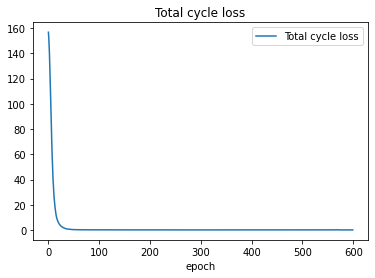

In [52]:
plt.plot(history['cycle_loss'], label='Total cycle loss')
plt.legend(loc='best')
plt.title('Total cycle loss')
plt.xlabel('epoch')

In [54]:
history['used_time']

[]

Text(0, 0.5, 'second')

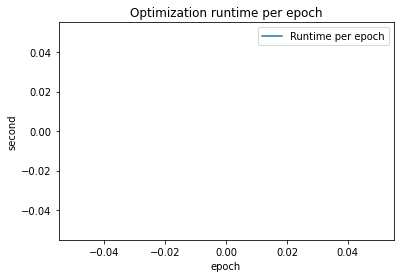

In [53]:
plt.plot(history['used_time'], label='Runtime per epoch')
plt.legend(loc='best')
plt.title('Optimization runtime per epoch')
plt.xlabel('epoch')
plt.ylabel('second')

X -- > Y

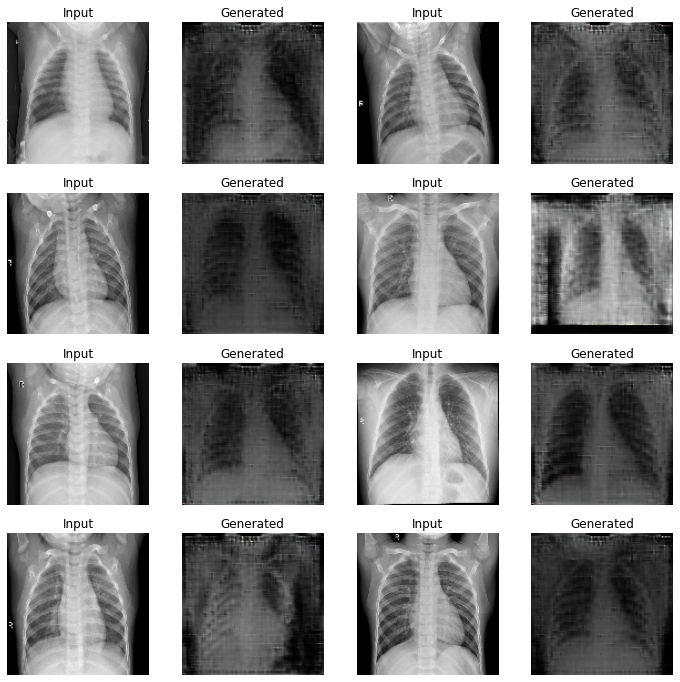

In [63]:
n_images = next(iter(normal_dataset))
gen_images = generator_g(n_images)

plt.figure(figsize=(12,12))

for i in range(4 * 4):
  plt.subplot(4, 4, 1+i)
  plt.axis(False)
  if i % 2 == 0:
    image = tf.keras.preprocessing.image.array_to_img(n_images[i,:,:,:])
    plt.imshow(image)
    plt.title('Input')
  else:
    image = tf.keras.preprocessing.image.array_to_img(gen_images[i,:,:,:])
    plt.imshow(image)
    plt.title('Generated')

In [64]:
input_images = []
generated_images = []
for i in range(n_images.shape[0]):
  input_images.append(tf.keras.preprocessing.image.array_to_img(n_images[i, :, :, :]).convert('L'))
  generated_images.append(tf.keras.preprocessing.image.array_to_img(gen_images[i, :, :, :]).convert('L'))

MSE = []
RMSE = []
PSNR = []
UQI = []
SCC = []
RASE =[]
SAM = []
VIF = []

for j in range(len(input_images)):
  gen = tf.keras.preprocessing.image.img_to_array(generated_images[j]).astype('uint8')
  org = tf.keras.preprocessing.image.img_to_array(input_images[j]).astype('uint8')
  MSE.append(mse(gen,org))
  RMSE.append(rmse(gen, org))
  PSNR.append(psnr(gen, org))
  UQI.append(uqi(gen, org))
  SCC.append(scc(gen, org))
  RASE.append(rase(gen, org))
  SAM.append(sam(gen, org))
  VIF.append(vifp(gen, org))

In [65]:
MSE = np.array(MSE)
RMSE = np.array(RMSE)
PSNR = np.array(PSNR)
UQI = np.array(UQI)
SCC = np.array(SCC)
RASE = np.array(RASE)
SAM = np.array(SAM)
VIF = np.array(VIF)

print(f"MSE ---- mean: {MSE.mean()}, std: {MSE.std()} ")
print(f"RMSE: ---- mean: {RMSE.mean()}, std: {RMSE.std()} ")
print(f"PSNR: ---- mean: {PSNR.mean()}, std: {PSNR.std()} ")
print(f"UQI: ---- mean: {UQI.mean()}, std: {UQI.std()} ")
print(f"SCC: ---- mean: {SCC.mean()}, std: {SCC.std()} ")
print(f"RASE: ---- mean: {RASE.mean()}, std: {RASE.std()} ")
print(f"SAM: ---- mean: {SAM.mean()}, std: {SAM.std()} ")
print(f"VIF: ---- mean: {VIF.mean()}, std: {VIF.std()} ")

MSE ---- mean: 6685.0290422439575, std: 2953.053650433248 
RMSE: ---- mean: 79.68401778892884, std: 18.316286502935846 
PSNR: ---- mean: 10.349700562154199, std: 2.1176231376430867 
UQI: ---- mean: 0.5252379626661035, std: 0.1790295584413553 
SCC: ---- mean: 0.028492228643304827, std: 0.010786241097074581 
RASE: ---- mean: 10573.521767965669, std: 5702.952693806328 
SAM: ---- mean: 0.38925870748667013, std: 0.07759205393024043 
VIF: ---- mean: 0.1934384828179797, std: 0.05123153719298733 


In [66]:
preds = classifier(gen_images)
true_labels = tf.zeros([64,1])
print(f"classify accuracy: {get_accuracy(true_labels, preds)}")

classify accuracy: 0.9375


Y --> Y

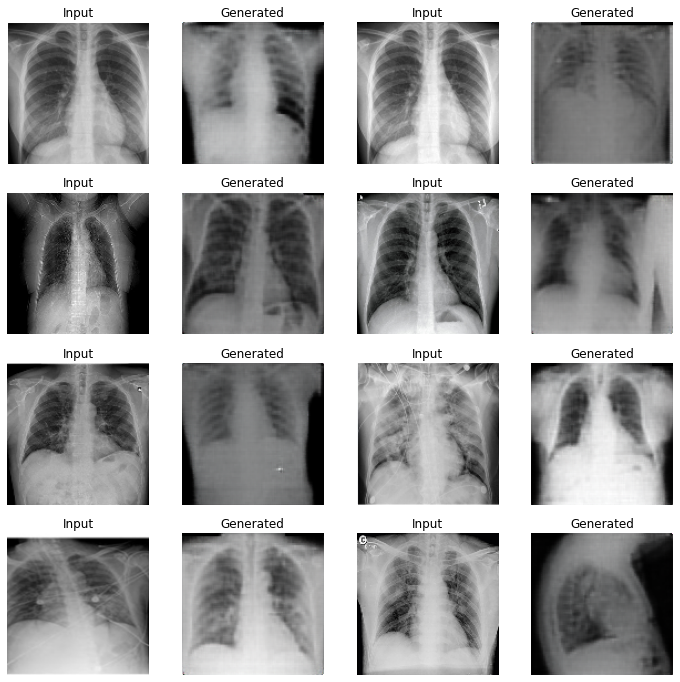

In [67]:
n_images = next(iter(covid_dataset))
gen_images = generator_g(n_images)

plt.figure(figsize=(12,12))

for i in range(4 * 4):
  plt.subplot(4, 4, 1+i)
  plt.axis(False)
  if i % 2 == 0:
    image = tf.keras.preprocessing.image.array_to_img(n_images[i,:,:,:])
    plt.imshow(image)
    plt.title('Input')
  else:
    image = tf.keras.preprocessing.image.array_to_img(gen_images[i,:,:,:])
    plt.imshow(image)
    plt.title('Generated')

In [61]:
input_images = []
generated_images = []
for i in range(n_images.shape[0]):
  input_images.append(tf.keras.preprocessing.image.array_to_img(n_images[i, :, :, :]).convert('L'))
  generated_images.append(tf.keras.preprocessing.image.array_to_img(gen_images[i, :, :, :]).convert('L'))

MSE = []
RMSE = []
PSNR = []
UQI = []
SCC = []
RASE =[]
SAM = []
VIF = []

for j in range(len(input_images)):
  gen = tf.keras.preprocessing.image.img_to_array(generated_images[j]).astype('uint8')
  org = tf.keras.preprocessing.image.img_to_array(input_images[j]).astype('uint8')
  MSE.append(mse(gen,org))
  RMSE.append(rmse(gen, org))
  PSNR.append(psnr(gen, org))
  UQI.append(uqi(gen, org))
  SCC.append(scc(gen, org))
  RASE.append(rase(gen, org))
  SAM.append(sam(gen, org))
  VIF.append(vifp(gen, org))

Y -- > Y


/usr/local/lib/python3.7/dist-packages/sewar/full_ref.py:248: RuntimeWarning: divide by zero encountered in true_divide
  rase_map = (100./M) * np.sqrt( np.sum(rmse_map**2,axis=2) / N )
/usr/local/lib/python3.7/dist-packages/sewar/full_ref.py:248: RuntimeWarning: invalid value encountered in multiply
  rase_map = (100./M) * np.sqrt( np.sum(rmse_map**2,axis=2) / N )


In [62]:
MSE = np.array(MSE)
RMSE = np.array(RMSE)
PSNR = np.array(PSNR)
UQI = np.array(UQI)
SCC = np.array(SCC)
RASE = np.array(RASE)
SAM = np.array(SAM)
VIF = np.array(VIF)

print(f"MSE ---- mean: {MSE.mean()}, std: {MSE.std()} ")
print(f"RMSE: ---- mean: {RMSE.mean()}, std: {RMSE.std()} ")
print(f"PSNR: ---- mean: {PSNR.mean()}, std: {PSNR.std()} ")
print(f"UQI: ---- mean: {UQI.mean()}, std: {UQI.std()} ")
print(f"SCC: ---- mean: {SCC.mean()}, std: {SCC.std()} ")
print(f"RASE: ---- mean: {RASE.mean()}, std: {RASE.std()} ")
print(f"SAM: ---- mean: {SAM.mean()}, std: {SAM.std()} ")
print(f"VIF: ---- mean: {VIF.mean()}, std: {VIF.std()} ")

MSE ---- mean: 799.2282218933105, std: 869.9791837737265 
RMSE: ---- mean: 24.849923513143594, std: 13.479967480829607 
PSNR: ---- mean: 21.524422298495264, std: 4.856081733322232 
UQI: ---- mean: 0.948101844495242, std: 0.04854035442729256 
SCC: ---- mean: 0.22731609544253067, std: 0.06940710268644625 
RASE: ---- mean: nan, std: nan 
SAM: ---- mean: 0.08560327908225966, std: 0.036462078346138106 
VIF: ---- mean: 0.5269952123291908, std: 0.06553136161493499 


In [68]:
preds = classifier(gen_images)
true_labels = tf.zeros([64,1])
print(f"classify accuracy: {get_accuracy(true_labels, preds)}")

classify accuracy: 1.0


FID

In [69]:
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.datasets import cifar10

In [70]:
# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = tf.image.resize(image, new_shape)
		# store
		images_list.append(new_image)
	return asarray(images_list)

In [71]:
# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = np.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

In [72]:
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

87924736/87910968 [==============================] - 0s 0us/step


In [96]:
FID = []

for images in covid_dataset:
  images1 = images
  images2 = generator_g(images)
  images1 = preprocess_input(images1)
  images2 = preprocess_input(images2)
  fid = calculate_fid(classifier, images1, images2)
  FID.append(fid)

FID = np.array(FID)
print("Adaptive Cycle GAN------")
print(f'Adjusted FID Mean: {FID.mean()}, Std: {FID.std()}')

Adaptive Cycle GAN------
Adjusted FID Mean: 1.015925025077102e-06, Std: 7.086787371247547e-07


In [97]:
FID = []

for images in normal_dataset:
  images1 = images
  images2 = generator_g(images)
  images1 = preprocess_input(images1)
  images2 = preprocess_input(images2)
  fid = calculate_fid(classifier, images1, images2)
  FID.append(fid)

FID = np.array(FID)
print("Adaptive Cycle GAN------")
print(f'Adjusted FID Mean: {FID.mean()}, Std: {FID.std()}')

Adaptive Cycle GAN------
Adjusted FID Mean: 0.00029142866352278504, Std: 2.258862303546481e-05
